In [1]:
import scripts.init_gpu as init_gpu
import scripts.init_dataset as init_dataset
from scripts.triplet_functions import n_neurons
import pandas as pd


init_gpu.initialize_gpus()

locations = ['LOC1', 'LOC2']

print("Loading Dataset...")
# load the dataset
df = pd.read_csv(
    f"../dataset/processed/{locations[0]}-{locations[1]}-scaled-balanced.csv")

length = len(df.columns) - 2  # subtract the two label columns

# get train-test set
train_df, test_df, train_web_samples, test_web_samples = init_dataset.get_sample(
    df, locations, range(1500), 1200)

train_df.head()

2024-10-30 23:02:20.977057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 23:02:20.983985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 23:02:20.992079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 23:02:20.994499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 23:02:21.000506: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  2
Loading Dataset...
Training Websites: [1309, 228, 51, 563, 501, 457, 285, 209, 1385, 1116, 178, 1209, 864, 65, 61, 191, 447, 476, 1034, 1232, 54, 1149, 407, 1466, 1330, 1436, 1490, 859, 451, 919, 1206, 569, 13, 326, 1429, 865, 696, 1468, 318, 440, 689, 1492, 189, 778, 198, 735, 704, 1236, 541, 88, 940, 1098, 255, 775, 161, 1130, 600, 1287, 1266, 740, 1182, 393, 142, 93, 1354, 466, 592, 163, 1482, 206, 1456, 1462, 928, 1301, 747, 333, 758, 727, 429, 1372, 546, 1399, 1327, 146, 1247, 1300, 350, 1093, 1495, 334, 946, 777, 552, 1310, 1140, 449, 1402, 664, 114, 469, 1486, 646, 821, 548, 135, 432, 1161, 644, 435, 1342, 1022, 810, 1316, 939, 292, 542, 1493, 505, 1478, 1103, 538, 1197, 877, 1195, 817, 741, 1404, 283, 1043, 1010, 186, 96, 224, 313, 1285, 327, 1487, 1221, 130, 788, 781, 1220, 958, 1083, 514, 1133, 23, 234, 1099, 1419, 1312, 1463, 1498, 601, 890, 323, 929, 6, 539, 1025, 365, 1039, 217, 1280, 611, 1308, 1338, 1415, 1477, 1366, 765, 330, 1104, 1086, 1, 1226, 

/home/asil0892/doh_traffic_analysis/code/scripts/init_dataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=["Location"], inplace=True)


,Location,Website,0,1,2,3,4,5,6,7,...,116,117,118,119,120,121,122,123,124,125
0,LOC1,0,-1.086861,0.690199,0.647933,0.201517,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
1,LOC1,1005,1.095547,-1.585943,0.647933,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
2,LOC1,1005,1.095547,0.780047,-1.972790,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
3,LOC1,1005,-1.086861,0.690199,0.647933,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
4,LOC1,1005,1.095547,0.780047,0.183501,-0.828965,-2.083179,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604


In [2]:
import tensorflow as tf
location_to_onehot = {location: tf.keras.utils.to_categorical(i, num_classes=len(locations)) 
                          for i, location in enumerate(locations)}

In [3]:
@tf.function
def generate_traces(generator, source_traces, source_domain, target_domain, num_traces, trace_dim):
    """
    Generates synthetic traces from the source domain to the target domain.

    Args:
        generator: The trained generator model.
        source_traces: A tensor of source traces with shape (num_traces, trace_dim).
        source_domain: A one-hot encoded vector representing the source domain.
        target_domain: A one-hot encoded vector representing the target domain.
        num_traces: The number of synthetic traces to generate.
        trace_dim: The dimensionality of the trace (length of the trace).

    Returns:
        A NumPy array of synthetic traces with shape (num_traces, trace_dim).
    """

    # Generate random noise for each trace
    noise = tf.random.normal([num_traces, trace_dim], dtype=tf.float32)

    # Repeat the source and target domains across traces
    source_domain = tf.broadcast_to(source_domain, [num_traces, tf.shape(source_domain)[-1]])
    target_domain = tf.broadcast_to(target_domain, [num_traces, tf.shape(target_domain)[-1]])

    # Prepare generator input
    generator_inputs = tf.concat([noise, source_traces, source_domain, target_domain], axis=1)

    # Generate synthetic traces and convert to NumPy
    synthetic_traces = generator(generator_inputs)

    return synthetic_traces

In [4]:
from scripts.train_WCGAN import Generator
generator = Generator(2 * length + 2 * len(locations), 32, length)
generator.load_weights("../models/GAN/WCGAN/generator-e1000.keras")

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1730289748.984201 1606790 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730289748.984289 1606790 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730289748.984344 1606790 

In [5]:
def filter_and_sort_data(df, location_label):
    """
    Filter the dataframe by location label, sort by Website label, and drop specified columns.
    """
    return (df[df['Location'] == location_label]
            
            .sort_values(by=['Website'])
            .iloc[:, 2:]
            .reset_index(drop=True))

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from fastdtw import fastdtw

def get_euclidean_distance(a, b):
    return np.sum(np.square(a - b))


def evaluate_generator(sampling_location, target_location, num_websites):
    target_traces = filter_and_sort_data(test_df, target_location).astype('float32')
    sample_traces = filter_and_sort_data(test_df, sampling_location).astype('float32')


    for i in range(0, 200 * num_websites, 200):
        plt.figure()

        # real mean
        real_mean = np.mean(target_traces[i:i+200], axis=0)
        real_std = np.std(target_traces[i:i+200])

        plt.plot(real_mean, label='real')
        plt.fill_between(range(length),real_mean + real_std, real_mean - real_std, label='real std', alpha = 0.2)


        decoded_data = generate_traces(generator, sample_traces[i:i+200].astype('float32'), location_to_onehot['LOC1'].astype('float32'), location_to_onehot['LOC2'].astype('float32'), 200, length)
        # synth mean
        synthetic_mean = np.mean(decoded_data, axis=0)
        synthetic_std = np.std(decoded_data)

        dtw_distance, path = fastdtw(real_mean, synthetic_mean, dist=get_euclidean_distance)
        euclidean_distance = get_euclidean_distance(real_mean, synthetic_mean)

        plt.plot(synthetic_mean, label='synthetic mean')
        plt.fill_between(range(length), synthetic_mean + synthetic_std, synthetic_mean - synthetic_std, label='synth. std', alpha = 0.2)


        plt.xticks(range(0,length, 10), labels=range(0, length, 10))
        plt.title(f"{target_location}, {test_web_samples[i // 200]}, DTW: {dtw_distance:.2}, Ecld_dist: {euclidean_distance:.2}")
        plt.legend()
        plt.show()



/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


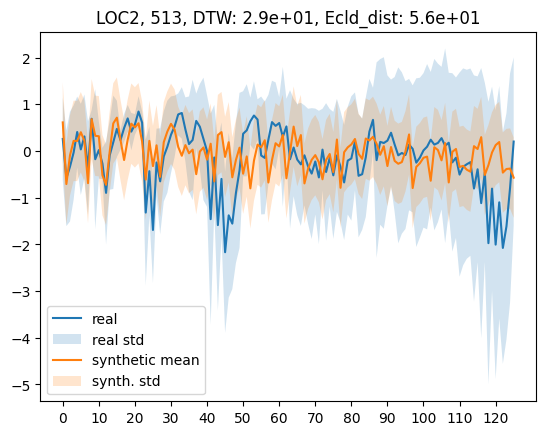

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


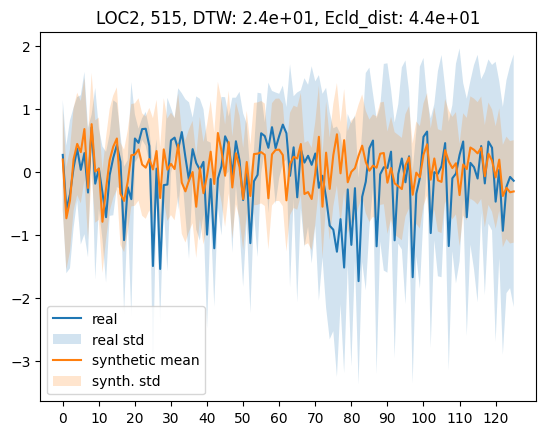

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


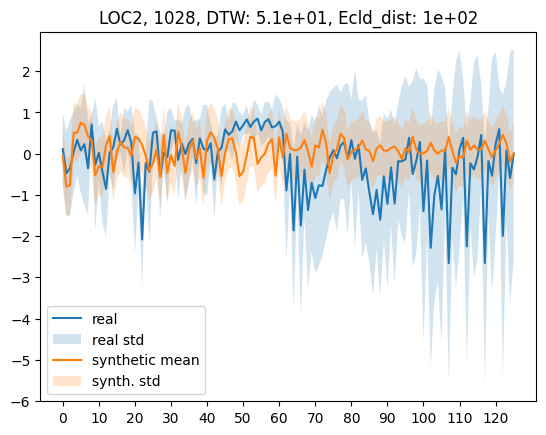

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


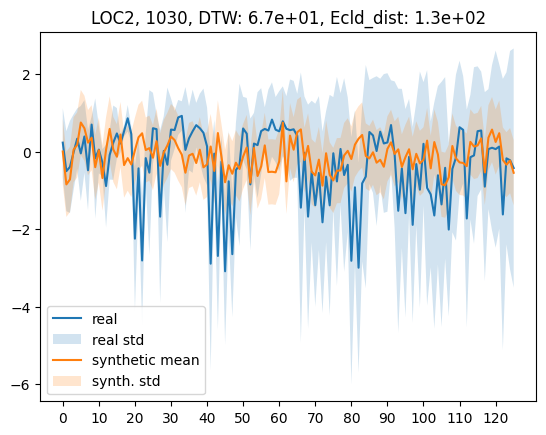

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


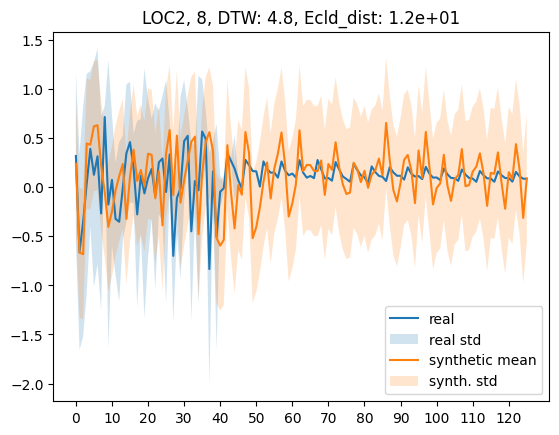

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


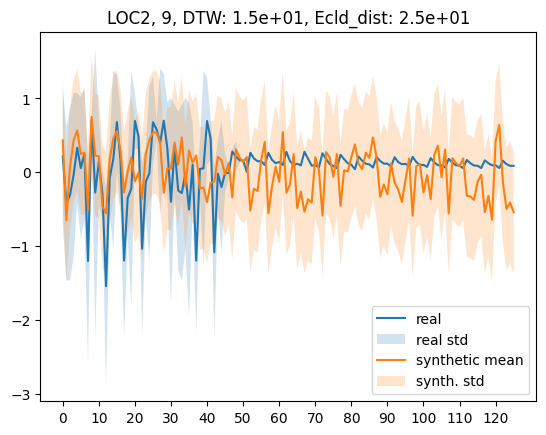

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


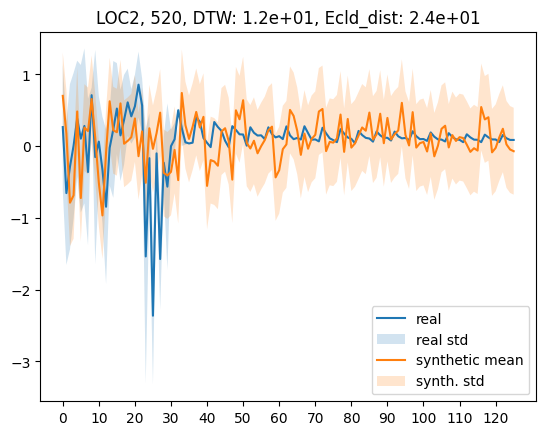

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


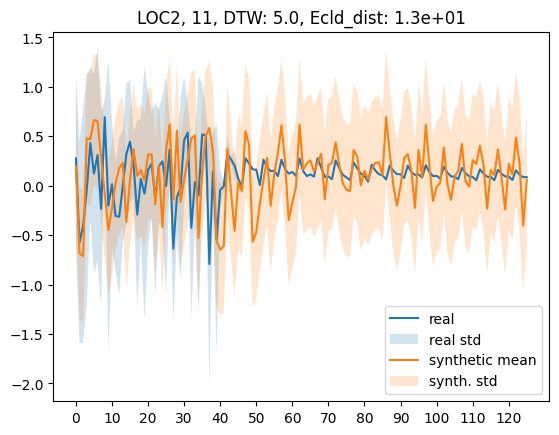

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


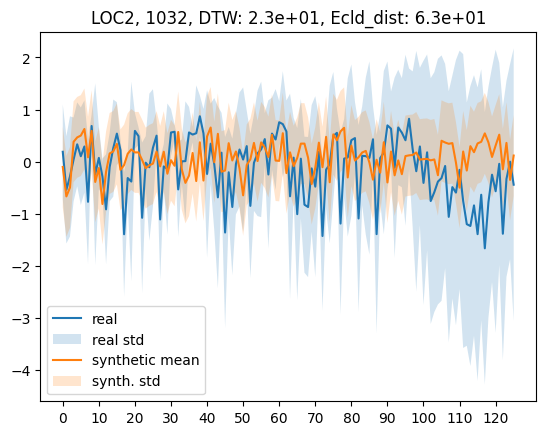

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


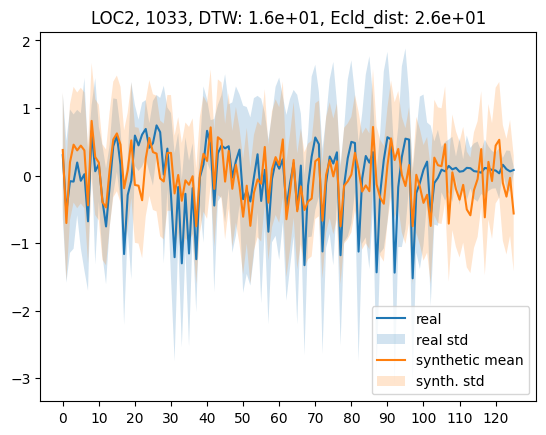

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


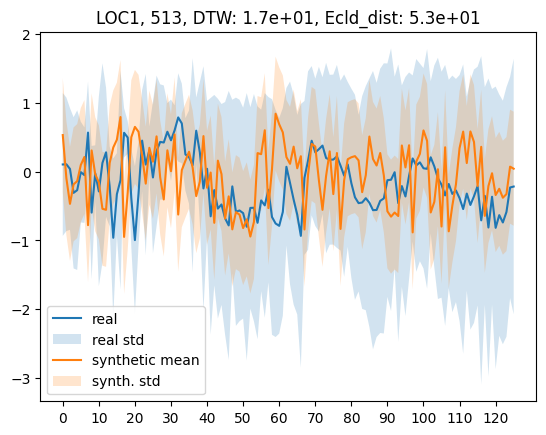

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


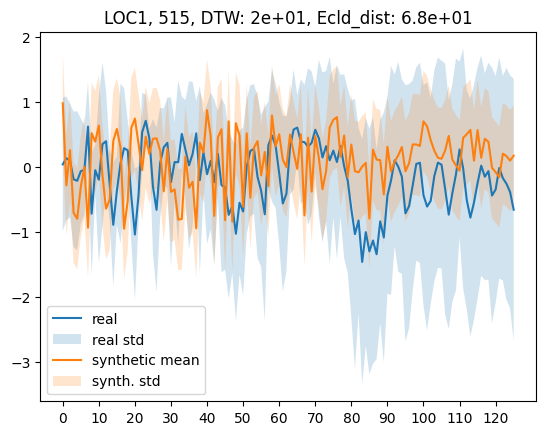

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


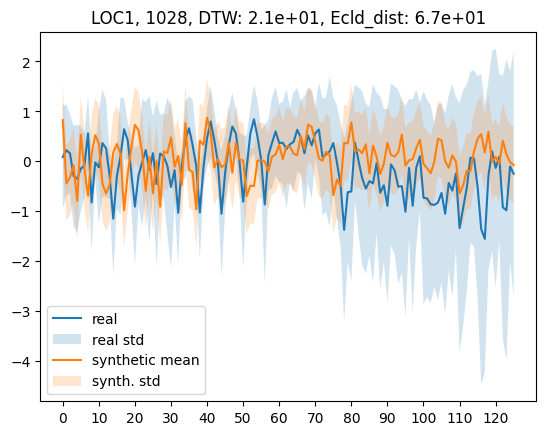

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


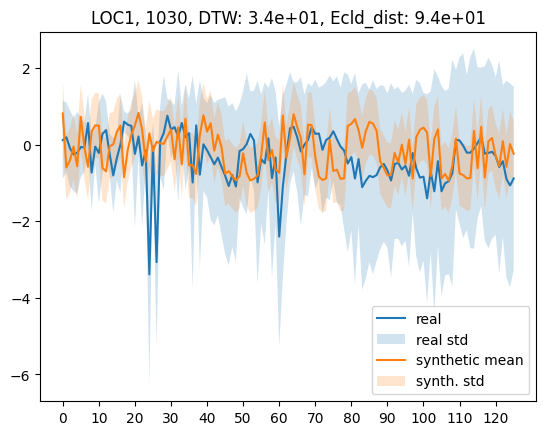

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


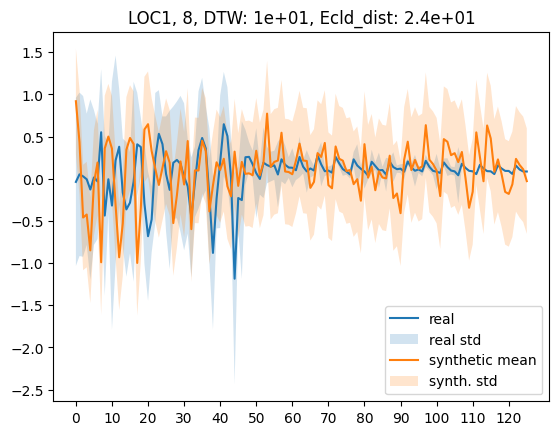

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


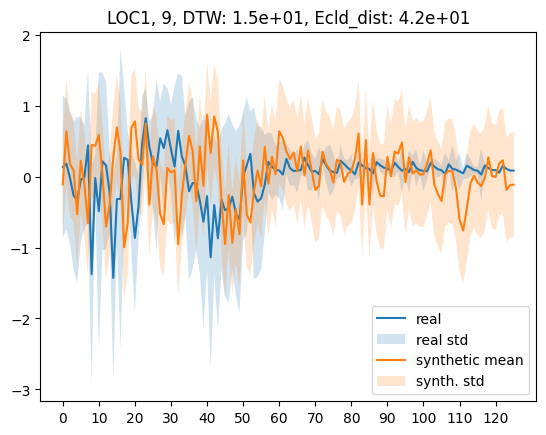

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


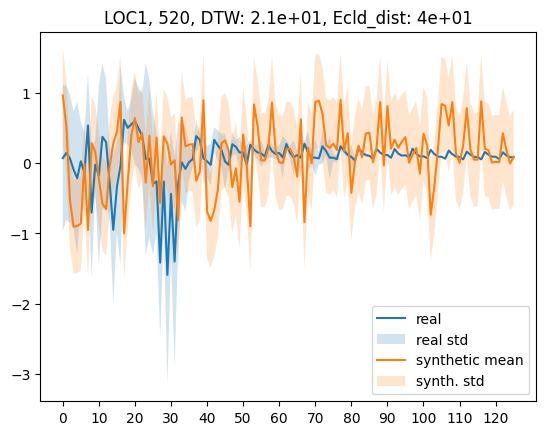

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


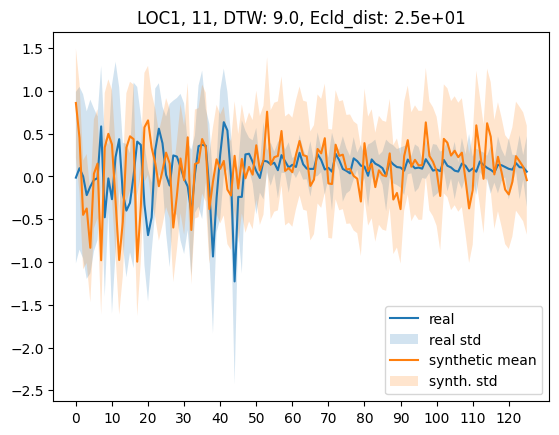

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


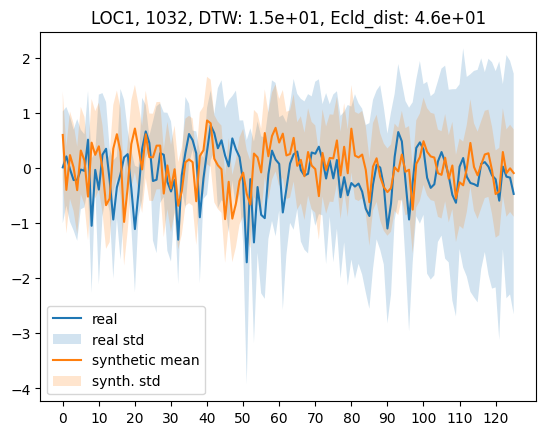

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


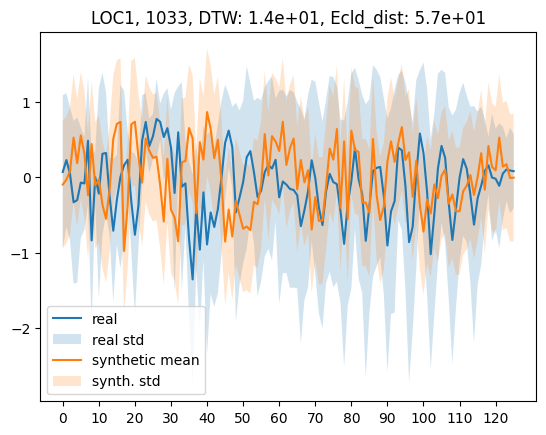

In [7]:
evaluate_generator('LOC1', 'LOC2', 10)
evaluate_generator('LOC2', 'LOC1', 10)